# Data Explorer

This notebook provides tools and visualizations to explore and analyze datasets in the project.

**Project:** CondGeoLDM  
**Author:** Pierre  
**Date:** 2024-06


In [2]:
import os
os.chdir('/projects/iktos/pierre/CondGeoLDM')
from configs.datasets_config import jump, geom_no_h
import copy
import build_jump_dataset, build_geom_dataset
import matplotlib.pyplot as plt
import numpy as np
import argparse
import tqdm
import wandb
from configs.datasets_config import get_dataset_info
from os.path import join
import build_jump_dataset
from qm9.models import get_optim, get_autoencoder, get_latent_diffusion
from equivariant_diffusion import en_diffusion
from equivariant_diffusion.utils import assert_correctly_masked
from equivariant_diffusion import utils as flow_utils
import torch
from qm9.utils import prepare_context, compute_mean_mad, prepare_embeddings
from train_test import train_epoch, test, analyze_and_save
import argparse
import umap.umap_ as umap

args_j = argparse.Namespace(
    exp_name='debug',
    train_diffusion=True,
    ae_path=None,
    trainable_ae=True,
    latent_nf=2,
    kl_weight=0.01,
    model='egnn_dynamics',
    probabilistic_model='diffusion',
    diffusion_steps=1000,
    diffusion_noise_schedule='polynomial_2',
    diffusion_loss_type='l2',
    diffusion_noise_precision=1e-05,
    n_epochs=500,
    batch_size=32,
    lr=0.0001,
    break_train_epoch=False,
    dp=True,
    condition_time=True,
    clip_grad=True,
    trace='hutch',
    n_layers=4,
    inv_sublayers=1,
    nf=256,
    tanh=True,
    attention=True,
    norm_constant=1,
    sin_embedding=False,
    ode_regularization=0.001,
    dataset='jump',
    filter_n_atoms=None,
    dequantization='argmax_variational',
    n_report_steps=50,
    wandb_usr=None,
    no_wandb=False,
    online=True,
    no_cuda=False,
    save_model=True,
    generate_epochs=1,
    num_workers=8,
    test_epochs=1,
    data_augmentation=False,
    conditioning=[],
    resume=None,
    start_epoch=0,
    ema_decay=0.9999,
    augment_noise=0,
    n_stability_samples=25,
    normalize_factors=[1, 4, 10],
    remove_h=False,
    include_charges=False,
    visualize_every_batch=10000,
    normalization_factor=1.0,
    aggregation_method='sum',
    filter_molecule_size=None,
    sequential=False,
    conditioning_mode='original',
    percent_train_ds=3,
    cuda=True,
    data_file= '/projects/iktos/pierre/CondGeoLDM/charac.npy',
)
args_g = copy.deepcopy(args_j)
args_g.dataset = 'geom'
args_g.data_file = '/projects/iktos/pierre/CondGeoLDM/data/geom/geom_drugs_no_h_30.npy'
args_g.remove_h = True



In [2]:
import numpy as np
charac = np.load('/projects/iktos/pierre/CondGeoLDM/charac.npy', allow_pickle=True)
# bugged_ids_during_3d_generation = np.load('/projects/iktos/pierre/CondGeoLDM/bugged_ids_during_3d_generation.npy', allow_pickle=True)

In [6]:
from collections import defaultdict, Counter

# Suppose this is your dataset: a list of molecules

# Dictionary to count molecule lengths
n_nodes = defaultdict(int)

# Counter to count all atoms
atom_counts = Counter()

for mol in charac:
    atoms = mol['atom_types']
    length = len(atoms)
    n_nodes[length] += 1
    atom_counts.update(mol['atom_types'])

# Convert defaultdict to regular dict
n_nodes = dict(n_nodes)
ordered_n_nodes = {k: n_nodes[k] for k in sorted(n_nodes.keys())}
print(ordered_n_nodes)

print("Molecule length distribution:", ordered_n_nodes)
print("Total atom counts:", dict(atom_counts))


{1: 1, 2: 1, 4: 9, 5: 6, 6: 17, 7: 31, 8: 75, 9: 119, 10: 223, 11: 290, 12: 440, 13: 557, 14: 839, 15: 1084, 16: 1465, 17: 2073, 18: 2902, 19: 4129, 20: 4938, 21: 5918, 22: 7014, 23: 7959, 24: 9264, 25: 9719, 26: 9198, 27: 8621, 28: 7844, 29: 6810, 30: 5835, 31: 4818, 32: 3698, 33: 2495, 34: 1347, 35: 906, 36: 450, 37: 274, 38: 159, 39: 137, 40: 117, 41: 110, 42: 86, 43: 61, 44: 54, 45: 41, 46: 30, 47: 18, 48: 18, 49: 16, 50: 10, 51: 11, 52: 14, 53: 10, 54: 9, 55: 6, 56: 11, 57: 8, 58: 12, 59: 2, 60: 4, 61: 7, 62: 7, 63: 4, 64: 5, 65: 8, 66: 3, 67: 3, 68: 5, 69: 5}
Molecule length distribution: {1: 1, 2: 1, 4: 9, 5: 6, 6: 17, 7: 31, 8: 75, 9: 119, 10: 223, 11: 290, 12: 440, 13: 557, 14: 839, 15: 1084, 16: 1465, 17: 2073, 18: 2902, 19: 4129, 20: 4938, 21: 5918, 22: 7014, 23: 7959, 24: 9264, 25: 9719, 26: 9198, 27: 8621, 28: 7844, 29: 6810, 30: 5835, 31: 4818, 32: 3698, 33: 2495, 34: 1347, 35: 906, 36: 450, 37: 274, 38: 159, 39: 137, 40: 117, 41: 110, 42: 86, 43: 61, 44: 54, 45: 41, 46: 

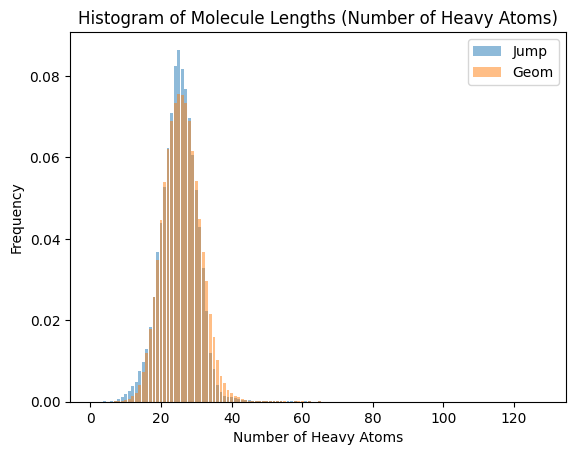

In [41]:
import matplotlib.pyplot as plt
# Transform positions into lists of triplets and pad with [0, 0, 0]
molecule_lengths = [ordered_n_nodes[length] for length in ordered_n_nodes.keys()]
# Calculate molecule lengths



def normalize_dict_values(input_dict):
    total = sum(input_dict.values())
    return {key: value / total for key, value in input_dict.items()}

geom_molecule_lengths = {1: 3, 2: 5, 3: 8, 4: 89, 5: 166, 6: 370, 7: 613, 8: 1214, 9: 1680, 10: 3315, 11: 5115, 12: 9873,
                13: 15422, 14: 28088, 15: 50643, 16: 82299, 17: 124341, 18: 178417, 19: 240446, 20: 308209, 21: 372900,
                22: 429257, 23: 477423, 24: 508377, 25: 522385, 26: 522000, 27: 507882, 28: 476702, 29: 426308,
                30: 375819, 31: 310124, 32: 255179, 33: 204441, 34: 149383, 35: 109343, 36: 71701, 37: 44050,
                38: 31437, 39: 20242, 40: 14971, 41: 10078, 42: 8049, 43: 4476, 44: 3130, 45: 1736, 46: 2030,
                47: 1110, 48: 840, 49: 750, 50: 540, 51: 810, 52: 591, 53: 453, 54: 540, 55: 720, 56: 300, 57: 360,
                58: 714, 59: 390, 60: 519, 61: 210, 62: 449, 63: 210, 64: 289, 65: 589, 66: 227, 67: 180, 68: 330,
                69: 330, 70: 150, 71: 60, 72: 210, 73: 60, 74: 180, 75: 120, 76: 30, 77: 150, 78: 30, 79: 60, 82: 60,
                85: 60, 86: 6, 87: 60, 90: 60, 91: 30}

qm9_molecule_lengths = {9: 83366, 8: 13625, 7: 2404, 6: 475, 5: 91, 4: 25, 3: 7, 1: 2, 2: 5}
norm_molecule_lengths = [molecule_lengths[i] / sum(molecule_lengths) for i in range(len(molecule_lengths))]
# Plot histogram of molecule lengths
plt.bar(ordered_n_nodes.keys(), norm_molecule_lengths , alpha=0.5, label='Jump')
plt.bar(geom_molecule_lengths.keys(), normalize_dict_values(geom_molecule_lengths).values(), alpha=0.5, label='Geom')
# plt.bar(qm9_molecule_lengths.keys(), normalize_dict_values(qm9_molecule_lengths).values(), alpha=0.5, label='QM9')
plt.title('Histogram of Molecule Lengths (Number of Heavy Atoms)')
plt.xlabel('Number of Heavy Atoms')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [2]:
jump_atom_types={'C': 2063934, 'N': 365627, 'O': 286672, 'S': 53099, 'Cl': 19617, 'F': 35165, 'Br': 3983, 'I': 270, 'P': 87, 'B': 22, 'Mo': 1, 'Si': 2, 'Se': 2, 'As': 1, 'K': 1, 'Sn': 1, 'Hg': 1, 'Na': 3, 'V': 1}
qm9_atom_types= {'C': 635559, 'N': 101476, 'O': 140202, 'F': 2323}
geom_atom_types = {'B': 290, 'C': 129988623, 'N': 20266722, 'O': 21669359, 'F': 1481844, 'Al': 1,
                  'Si': 250, 'P': 36290, 'S': 3999872, 'Cl': 1224394, 'As': 4, 'Br': 298702, 'I': 5377, 'Hg': 13, 'Bi': 34}

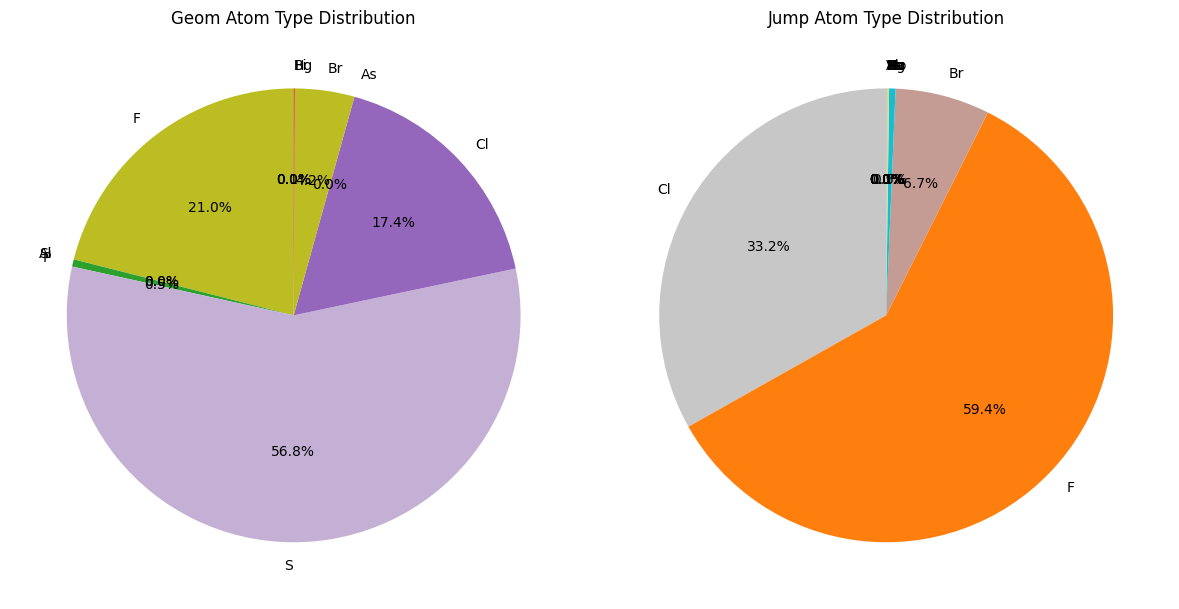

In [4]:
import matplotlib.pyplot as plt


# Get the union of all atom types
all_atom_types = set(qm9_atom_types.keys()).union(set(geom_atom_types.keys())).union(set(jump_atom_types.keys()))

# Define consistent colors for each atom type
colors = plt.cm.tab20(range(len(all_atom_types)))
atom_colors = {atom: colors[i] for i, atom in enumerate(sorted(all_atom_types))}

# Prepare data for pie charts
qm9_labels = list(qm9_atom_types.keys())
qm9_sizes = list(qm9_atom_types.values())
qm9_colors = [atom_colors[atom] for atom in qm9_labels]

jump_labels = list(jump_atom_types.keys())[4:]
jump_sizes = list(jump_atom_types.values())[4:]
jump_colors = [atom_colors[atom] for atom in jump_labels][4:]

geom_labels = list(geom_atom_types.keys()) [4:]
geom_sizes = list(geom_atom_types.values()) [4:]
geom_colors = [atom_colors[atom] for atom in geom_labels] [4:]

# Plot pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # QM9 pie chart
# axes[0].pie(qm9_sizes, labels=qm9_labels, colors=qm9_colors, autopct='%1.1f%%', startangle=90)
# axes[0].set_title('QM9 Atom Type Distribution')

# Jump pie chart
axes[1].pie(jump_sizes, labels=jump_labels, colors=jump_colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Jump Atom Type Distribution')
# Geom pie chart
axes[0].pie(geom_sizes, labels=geom_labels, colors=geom_colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Geom Atom Type Distribution')

plt.tight_layout()
plt.show()


In [33]:
split_data_j = build_jump_dataset.load_split_data(args_j.data_file, val_proportion=0.1, test_proportion=0.1, filter_size=args_j.filter_molecule_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset_info_j = get_dataset_info(args_j.dataset, args_j.remove_h)
transform = build_jump_dataset.JumpTransform(dataset_info_j, args_j.include_charges, device, args_j.sequential)
dataloaders_j = {}
for key, data_list in zip(['train', 'valid', 'test'], split_data_j):
    dataset = build_jump_dataset.JumpDataset(data_list, transform=transform, percent_train_ds=10)
    shuffle = (key == 'train') and not args_j.sequential
    dataloaders_j[key] = build_jump_dataset.JumpDataLoader(
    sequential=args_j.sequential, dataset=dataset, batch_size=args_j.batch_size,
    shuffle=False)
del split_data_j

In [3]:
split_data_g = build_geom_dataset.load_split_data(args_g.data_file, val_proportion=0.1, test_proportion=0.1, filter_size=args_g.filter_molecule_size)
dataset_info_g = get_dataset_info(args_g.dataset, args_g.remove_h)
transform = build_geom_dataset.GeomDrugsTransform(dataset_info_g, args_g.include_charges, device, args_g.sequential)
dataloaders_g = {}
for key, data_list in zip(['train', 'val', 'test'], split_data_g):
    dataset = build_geom_dataset.GeomDrugsDataset(data_list, transform=transform, percent_train_ds=args_g.percent_train_ds)
    shuffle = (key == 'train') and not args_g.sequential

    # Sequential dataloading disabled for now.
    dataloaders_g[key] = build_geom_dataset.GeomDrugsDataLoader(
        sequential=args_g.sequential, dataset=dataset, batch_size=args_g.batch_size, 
        shuffle=shuffle)
del split_data_g

Loading conformations from /projects/iktos/pierre/CondGeoLDM/data/geom/geom_drugs_no_h_30.npy
Total number of conformers loaded 178971775


In [66]:
next_iter_j = next(iter(dataloaders_j['train']))
next_iter_g = next(iter(dataloaders_g['train']))
# print(next_iter_j)
# print(next_iter_g)
print(next_iter_g)

{'positions': tensor([[[ 6.2765,  1.7595,  1.0801],
         [ 5.4304,  0.6472,  0.4684],
         [ 4.4959,  1.1934, -0.6128],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[-2.6286, -4.1097,  0.1833],
         [-2.0857, -2.7959,  0.4267],
         [-2.3854, -1.7693, -0.3914],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 6.2121,  1.1680,  0.1803],
         [ 4.8491,  1.5001,  0.0548],
         [ 4.1007,  0.8289, -0.8541],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        ...,

        [[-0.1915, -1.8051, -1.7431],
         [ 1.0024, -1.5682, -0.8250],
         [ 1.5997, -2.8818, -0.3262],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]

## Statistics on Jump and Geom

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def compute_dataset_position_statistics(dataloader, position_key='positions', 
                                       mask_key='atom_mask', bin_size=0.2):
    """
    Compute position statistics with fixed bin ranges for histograms
    """
    # Initialize accumulators
    all_x = []
    all_y = []
    all_z = []
    total_valid = 0
    batches = 0
    # First pass: collect all non_zero values to determine global range
    for batch in tqdm(dataloader, desc="Collecting data range"):
        positions = batch[position_key].cpu().float()
        atom_mask = batch[mask_key].cpu().bool()
        
        valid_mask = atom_mask.flatten()
        x_vals = positions[..., 0].flatten()[valid_mask]
        y_vals = positions[..., 1].flatten()[valid_mask]
        z_vals = positions[..., 2].flatten()[valid_mask]
        all_x.append(x_vals)
        all_y.append(y_vals)
        all_z.append(z_vals)
        
        total_valid += valid_mask.sum().item()
        batches += 1

    # Concatenate all values
    x_vals = torch.cat(all_x) if all_x else torch.tensor([])
    y_vals = torch.cat(all_y) if all_y else torch.tensor([])
    z_vals = torch.cat(all_z) if all_z else torch.tensor([])
    all_vals = torch.cat([x_vals, y_vals, z_vals]) if total_valid > 0 else torch.tensor([])
    
    # Calculate global min/max for consistent binning
    global_min = min(
        x_vals.min().item() if x_vals.numel() > 0 else 0,
        y_vals.min().item() if y_vals.numel() > 0 else 0,
        z_vals.min().item() if z_vals.numel() > 0 else 0
    )
    global_max = max(
        x_vals.max().item() if x_vals.numel() > 0 else 0,
        y_vals.max().item() if y_vals.numel() > 0 else 0,
        z_vals.max().item() if z_vals.numel() > 0 else 0
    )
    
    # Create consistent bin edges
    bin_edges = np.arange(global_min, global_max + bin_size, bin_size)
    
    # Compute histograms
    def compute_histogram(vals):
        if vals.numel() == 0:
            return np.zeros(len(bin_edges)-1)
        hist, _ = np.histogram(vals.numpy(), bins=bin_edges)
        return hist

    x_hist = compute_histogram(x_vals)
    y_hist = compute_histogram(y_vals)
    z_hist = compute_histogram(z_vals)
    
    # Helper function to compute statistics
    def compute_stats(tensor):
        if tensor.numel() == 0:
            return None
        tensor_np = tensor.numpy()
        return {
            'mean': np.mean(tensor_np),
            'std': np.std(tensor_np),
            'min': np.min(tensor_np),
            'max': np.max(tensor_np),
            'median': np.median(tensor_np),
            'q1': np.quantile(tensor_np, 0.25),
            'q3': np.quantile(tensor_np, 0.75),
            'count': len(tensor_np)
        }
    
    # Compute statistics
    stats = {
        'overall': compute_stats(all_vals),
        'x': compute_stats(x_vals),
        'y': compute_stats(y_vals),
        'z': compute_stats(z_vals),
        'total_valid_atoms': total_valid,
        'batches_processed': batches,
        'x_hist_counts': x_hist,
        'y_hist_counts': y_hist,
        'z_hist_counts': z_hist,
        'bin_edges': bin_edges
    }
    
    return stats

In [61]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_position_statistics(stats_dict, dataset_name="", bin_size=0.2):
    """
    Visualize position statistics with fixed bin handling
    """
    if not stats_dict['overall']:
        print("No valid position data found")
        return

    # Extract statistics
    overall = stats_dict['overall']
    x_stats = stats_dict['x']
    y_stats = stats_dict['y']
    z_stats = stats_dict['z']
    total_atoms = stats_dict['total_valid_atoms']
    batches = stats_dict['batches_processed']
    
    # Get histogram data
    bin_edges = stats_dict['bin_edges']
    x_hist = stats_dict['x_hist_counts']
    y_hist = stats_dict['y_hist_counts']
    z_hist = stats_dict['z_hist_counts']
    
    # Create figure
    fig = plt.figure(figsize=(16, 12), dpi=100)
    fig.suptitle(f"Position Statistics - {dataset_name}\n"
                 f"Total Atoms: {total_atoms:,} | Batches: {batches}", 
                 fontsize=16, fontweight='bold')
    
    gs = GridSpec(3, 3, figure=fig)
    
    # 1. Summary Statistics Table
    ax_table = fig.add_subplot(gs[0, 0])
    ax_table.axis('off')
    
    table_data = [
        ["", "Overall", "X", "Y", "Z"],
        ["Mean", f"{overall['mean']:.4f}", f"{x_stats['mean']:.4f}", 
         f"{y_stats['mean']:.4f}", f"{z_stats['mean']:.4f}"],
        ["Std Dev", f"{overall['std']:.4f}", f"{x_stats['std']:.4f}", 
         f"{y_stats['std']:.4f}", f"{z_stats['std']:.4f}"],
        ["Min", f"{overall['min']:.4f}", f"{x_stats['min']:.4f}", 
         f"{y_stats['min']:.4f}", f"{z_stats['min']:.4f}"],
        ["Max", f"{overall['max']:.4f}", f"{x_stats['max']:.4f}", 
         f"{y_stats['max']:.4f}", f"{z_stats['max']:.4f}"],
        ["Median", f"{overall['median']:.4f}", f"{x_stats['median']:.4f}", 
         f"{y_stats['median']:.4f}", f"{z_stats['median']:.4f}"],
        ["Count", f"{overall['count']:,}", f"{x_stats['count']:,}", 
         f"{y_stats['count']:,}", f"{z_stats['count']:,}"]
    ]
    
    table = ax_table.table(cellText=table_data, 
                           loc='center', 
                           cellLoc='center',
                           colWidths=[0.15, 0.2, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    ax_table.set_title("Summary Statistics", fontsize=12, pad=20)
    
    # 2. Combined Histograms (FIXED)
    ax_combined = fig.add_subplot(gs[0, 1:])
    
    # Use consistent bin centers
    bin_centers = bin_edges[:-1] + bin_size/2
    
    for hist, color, label in zip([x_hist, y_hist, z_hist], 
                                 ['#1f77b4', '#ff7f0e', '#2ca02c'], 
                                 ['X-axis', 'Y-axis', 'Z-axis']):
        ax_combined.bar(bin_centers, hist, width=bin_size*0.8, 
                        alpha=0.7, label=label, color=color,
                        edgecolor='none')
    
    ax_combined.axvline(overall['mean'], color='r', linestyle='--', 
                        label=f"Overall Mean: {overall['mean']:.2f}")
    ax_combined.set_title("Coordinate Distributions", fontsize=12)
    ax_combined.set_xlabel("Coordinate Value")
    ax_combined.set_ylabel("Frequency (log scale)")
    ax_combined.set_yscale('log')
    ax_combined.legend()
    ax_combined.grid(alpha=0.2)
    
    # 3. Per-Axis Plots (FIXED)
    axes = ['x', 'y', 'z']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    titles = ['X-Axis Distribution', 'Y-Axis Distribution', 'Z-Axis Distribution']
    hists = [x_hist, y_hist, z_hist]
    stats_list = [x_stats, y_stats, z_stats]
    
    for i, (axis, color, title, hist, stats) in enumerate(zip(
            axes, colors, titles, hists, stats_list)):
        
        ax = fig.add_subplot(gs[1, i])
        bin_centers = bin_edges[:-1] + bin_size/2
        
        ax.bar(bin_centers, hist, width=bin_size*0.8, 
               alpha=0.8, color=color, edgecolor='none')
        
        ax.axvline(stats['mean'], color='r', linestyle='-', 
                   label=f"Mean: {stats['mean']:.2f}")
        ax.axvline(stats['median'], color='g', linestyle='-', 
                   label=f"Median: {stats['median']:.2f}")
        
        ax.axvline(stats['q1'], color='b', linestyle=':', alpha=0.7)
        ax.axvline(stats['q3'], color='b', linestyle=':', alpha=0.7)
        ax.axvspan(stats['q1'], stats['q3'], alpha=0.1, color=color)
        
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Coordinate Value")
        ax.set_ylabel("Frequency")
        ax.legend(loc='upper right')
        ax.grid(alpha=0.1)

    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"position_stats_{dataset_name}.png", bbox_inches='tight')

    plt.show()

In [ ]:
jump_stats_j = compute_dataset_position_statistics((dataloaders_j['train']))
plot_position_statistics(jump_stats_j, dataset_name='Jump Dataset', bin_size=0.2)
geom_stats_g = compute_dataset_position_statistics((dataloaders_g['train']))
plot_position_statistics(geom_stats_g, dataset_name='Geom Dataset', bin_size=0.2)

### Umap on both DS

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
import tqdm

radius = 2
n_bits = 2048

generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)

fingerprints_g = []
valid_smiles_g = []
valid_smiles_j = []

with open('/projects/iktos/pierre/CondGeoLDM/data/geom/geom_drugs_smiles.txt', "r") as f:
    for line in tqdm.tqdm(f, desc="Processing Geom Data (eta 1,5 min)"):
        smi = line.strip()
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        fp = generator.GetFingerprint(mol)
        # arr = np.zeros((n_bits,), dtype=int)
        # DataStructs.ConvertToNumpyArray(fp, arr)
        # fingerprints_g.append(arr)
        # valid_smiles_g.append(smi)
        fingerprints_g. append(fp)
        
fingerprints_j = []
for mol in tqdm.tqdm(charac, desc="Processing Jump Data"):
    inchi = mol["Inchi"]
    mol = Chem.MolFromInchi(inchi)
    if mol is None:
        continue
    fp = generator.GetFingerprint(mol)
    # arr = np.zeros((n_bits,), dtype=int)
    # DataStructs.ConvertToNumpyArray(fp, arr)
    # fingerprints_j.append(arr)
    # valid_smiles_j.append(inchi)
    fingerprints_j.append(fp)
    
# np.save("geom_fingerprints.npy", fingerprints_g)
# np.save("jump_fingerprints.npy", fingerprints_j)
# fingerprints_j = np.load("/projects/iktos/pierre/CondGeoLDM/data/jump_data/jump_fingerprints.npy", allow_pickle=True)
# fingerprints_g = np.load("/projects/iktos/pierre/CondGeoLDM/data/jump_data/geom_fingerprints.npy", allow_pickle=True)

Processing Geom Data (eta 1,5 min): 292035it [01:05, 4433.26it/s]
Processing Jump Data:  14%|█▍        | 15903/112360 [00:08<00:50, 1892.72it/s][14:19:43] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

Processing Jump Data:  16%|█▋        | 18494/112360 [00:09<00:47, 1993.78it/s][14:19:44] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

Processing Jump Data:  17%|█▋        | 18893/112360 [00:10<00:47, 1983.94it/s][14:19:45] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

Processing Jump Data:  17%|█▋        | 19092/112360 [00:10<00:47, 1974.64it/s][14:19:45] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

Processing Jump Data:  44%|████▍     | 49618/112360 [00:26<00:34, 1803.64it/s][14:20:01] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

Processing Jump Data:  70%|███████   | 78816/112360 [00:42<

In [ ]:
fingerprints_j = np.load("/projects/iktos/pierre/CondGeoLDM/data/jump_data/jump_fingerprints.npy", allow_pickle=True)
fingerprints_g = np.load("/projects/iktos/pierre/CondGeoLDM/data/jump_data/geom_fingerprints.npy", allow_pickle=True)
# X = np.vstack([fingerprints_j ,fingerprints_g])
# labels = np.array(['jump'] * len(fingerprints_j) + ['geom'] * len(fingerprints_g))
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
# X_umap = reducer.fit_transform(X)

# Visualization
colors = {'jump': 'steelblue', 'geom': 'darkorange'}
plt.figure(figsize=(10, 8))
# Shuffle the data and labels together
shuffled_indices = np.random.permutation(len(X_umap))
X_umap_shuffled = X_umap[shuffled_indices]
labels_shuffled = labels[shuffled_indices]
for i in range(len(X_umap_shuffled)):
    x, y = X_umap_shuffled[i]
    label = labels_shuffled[i]
    plt.scatter(x, y, c=colors[label], alpha=0.7, s=20)
plt.title('UMAP Projection of Jump and Geom Fingerprints')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.savefig('umap_projection_jump_geom_1.png', dpi=300)
plt.show()

/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print(os.cpu_count())


24


In [ ]:
import multiprocessing
similarities = []
def init_pool(fj):
    global fingerprints_j_global
    fingerprints_j_global = fj

def compute_similarity(fp_g):
    try:
        return DataStructs.BulkTanimotoSimilarity(fp_g, fingerprints_j)
    except Exception as e:
        print(f"Error computing similarity: {e}")
        return None  

# This works if fingerprints_j is small and can be broadcast into each process
with multiprocessing.Pool(processes=8) as pool:
    results = list(tqdm.notebook.tqdm(pool.imap(compute_similarity, fingerprints_g), total=len(fingerprints_g)))

  0%|          | 0/292035 [00:00<?, ?it/s]

: 

In [3]:
import numpy as np
import pandas as pd

best_hits = np.load('/projects/iktos/pierre/CondGeoLDM/data/jump_data/best_hits.npy', allow_pickle=True)
best_hits = pd.DataFrame(best_hits)
best_hits

,0
0,0.440678
1,1.000000
2,0.459016
3,0.378788
4,0.397059
...,...
112405,0.523077
112406,1.000000
112407,0.475410
112408,0.533333


In [6]:
import matplotlib.pyplot as plt

# Extract the values from the DataFrame
values = best_hits[0]

# Define bins: 100 evenly spaced bins between 0 and 1, and a special bin for the value 1
bins = [i / 100 for i in range(100)] + [1.01]

# Create the histogram
plt.hist(values, bins=bins, edgecolor='black', alpha=0.7)

# Customize the plot
plt.title('Highest Tanimoto Similarity Values from Jump to Geom')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks([i / 10 for i in range(11)], rotation=45)
plt.grid(axis='y', alpha=0.3)
# Annotate the bar for the bin with value 1.0
bin_index = bins.index(1.01) - 1  # Find the index of the bin corresponding to 1.0
frequency = plt.hist(values, bins=bins)[0][bin_index]  # Get the frequency for the bin
plt.text(1.0, frequency + 50, str(int(frequency)), ha='center', va='bottom', fontsize=10, color='red')
# Show the plot
plt.tight_layout()
plt.show()
plt.savefig('best_hits_histogram.png', dpi=300)

/tmp/ipykernel_4057983/490226981.py:24: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [ ]:
import os
os.chdir('/projects/iktos/pierre/CondGeoLDM')
files = load_xyz_files(path)
files = sorted(files)
save_paths = []

for i in range(len(files)):
    file = files[i]

    positions, one_hot, charges = load_molecule_xyz(file, dataset_info=dataset_info)

    atom_type = torch.argmax(one_hot, dim=1).numpy()
    fn = file[:-4] + '.png'
    plot_data3d(positions, atom_type, dataset_info=dataset_info,
                save_path=fn, spheres_3d=spheres_3d, alpha=1.0)
    save_paths.append(fn)

imgs = [imageio.imread(fn) for fn in save_paths]
dirname = os.path.dirname(save_paths[0])
gif_path = dirname + '/output.gif'
print(f'Creating gif with {len(imgs)} images')
# Add the last frame 10 times so that the final result remains temporally.
# imgs.extend([imgs[-1]] * 10)
imageio.mimsave(gif_path, imgs, subrectangles=True)

if wandb is not None:
    wandb.log({mode: [wandb.Video(gif_path, caption=gif_path)]})
# for file in save_paths:
    #     os.remove(file)



debug


TypeError: mimwrite() missing 1 required positional argument: 'ims'